<a href="https://colab.research.google.com/github/pxbradley/ml_hw/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the white blood cell images into phase/amplitude objects, and then process them through a microscope simulator as we did in HW4, add noise, and then feed the resulting images into a CNN for classification. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the intensity of input illumination incident on the phase/amplitude objects to try to improve classification performance.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will instruct you to use specific values that we have tested and are known to give reasonable results.

Some code adapted from https://www.tensorflow.org/tutorials/quickstart/advanced


## 1. import stuff and load the dataset
As always, we split the dataset into training and testing. You can just run this code, you don't need to understand what's going on

In [1]:
# if this breaks please contact the TAs
!wget -O data.zip https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded
!unzip /content/data.zip
!unzip /content/PBC_dataset_normal_DIB > /dev/null

--2022-04-11 16:44:22--  https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/5a5a3b1a-0b1d-46bc-bff2-0420599d351b [following]
--2022-04-11 16:44:22--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/5a5a3b1a-0b1d-46bc-bff2-0420599d351b
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.92.152
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.92.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 281366219 (268M) [applicati

In [2]:
from tensorflow.python.ops.gen_math_ops import sub
# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

def load_and_crop(image_path, crop_size, normalized=False):
    image = Image.open(image_path) .resize([256,256])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# code to load all the data, assuming dataset is at PBC_dataset_normal_DIB relative path
cell_types = ['lymphocyte', 'monocyte', 'neutrophil']
cell_inds = np.arange(0, len(cell_types))
x_data = []
y_data = []
for cell_ind in cell_inds:
    all_images = glob.glob(os.path.join('PBC_dataset_normal_DIB', cell_types[cell_ind], '*.jpg'))
    x_data += [load_and_crop(image_path, 128) for image_path in all_images]
    y_data += [cell_ind]*len(all_images)

(4770, 128, 128) (4770, 3)
(1193, 128, 128) (1193, 3)


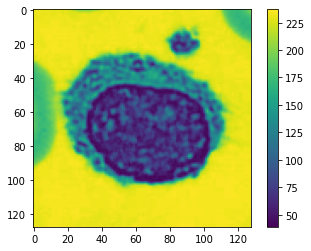

In [3]:
# generating train/val indices
folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.seed(0)
np.random.shuffle(train_indices)

x_data = np.array(x_data)
y_data = np.array(y_data)

x_train = x_data[train_indices]
y_train = np.eye(len(cell_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(cell_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:])
plt.colorbar()

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_test = x_val
y_test = y_val
x_train, x_test = x_train / 255.0, x_test / 255.0  # customary normalization to [0, 1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4770, 128, 128) (4770, 3)
(1193, 128, 128) (1193, 3)


## 2. convert the images into microscope samples
Like HW4, we'll just use an image that represents absorption, and then make an approximation to estimate its optical thickness. We will assume that the sample's optical thickness is directly proportional to how much light is absorbed by the sample, allowing you to use the image itself to define both the absorption and phase delay components of the simulated microscope samples. Please convert the images into amplitude/phase objects, assuming that the maximum absorption for a given sample is 1, and the maximum phase delay for each sample is 20 wavelengths. We'll assume the wavelength of the light in this microscope is 500 nm, or 0.5 µm.

In [5]:
wavelength = .5e-3 # units are mm; assuming green light
delta_x = 0.5*wavelength # let's sample at nyquist rate
num_samples = 128

# in real world, microscope samples are 3D and have thickness, which introduce a phase shift to the optical field
# For simplicity, let's further assume the sample thickness and amplitude are inversely correlated, which means the thicker the sample is,
# the more light it absorb.
def convert_images(sample_amplitude):
    sample_phase = 1 - sample_amplitude
    optical_thickness = 20 * wavelength
    return sample_amplitude * np.exp(1j * sample_phase*optical_thickness/wavelength)

x_train = convert_images(x_train)
x_test = convert_images(x_test)

Next, let's generate a new dataset that contains differently illuminated sample images. We will model a plane wave hitting this thin sample like we did for HW4. We will start by modeling 9 different illumination angles for each simulated sample of interest, provided by a 3x3 array of LEDs positioned beneath the sample of interest. Let's assume the center LED is directly beneath the specimen, and that the neighboring LEDs are offset by a 10 degree angle from the center. This will allow us to see how the images change with different illumination angles. Please recall that illumination from a particular angle shifts the sample spectrum across the microscope aperture, causing different components of the shifted spectrum to pass through and onto the detector for different illumination angles. The general process is exactly same as what was considered in HW4. Here, we will model the microscope aperture as a circle, whose effect within this simulation model is to allow only the center pixels of the sample spectrum to pass through the lens and onto the image sensor. Please model and show what the 9 uniquely illuminated images appear like.  

In [6]:
def crop_center(sample, cropx, cropy):
    y,x = sample.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return sample[starty:starty+cropy,startx:startx+cropx]

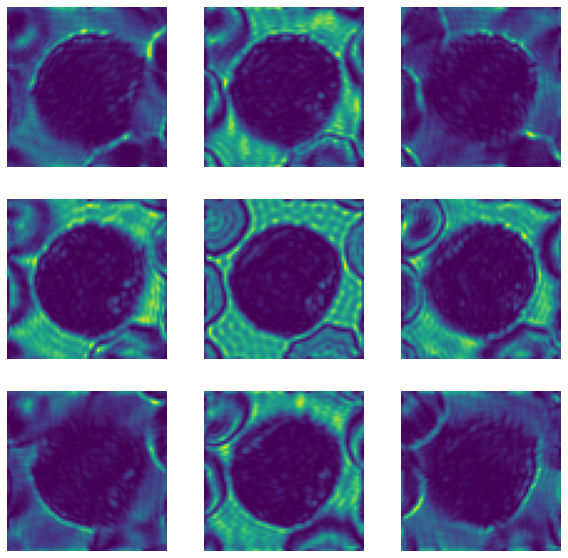

In [7]:
# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  128
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates.
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# define angles
plane_wave_angle_xy = np.array([[0,0], [10,0], [10,10], [0,10], [-10,10], [-10,0], [-10,-10], [0,-10], [10,-10]]) * np.pi/180

# generate illumination dataset
illumination_data = np.zeros((64, 64, 9))
sample = x_test[0]
for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
    # Define plane waves
    illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle[0]) * xx + np.sin(plane_wave_angle[1]) * yy))

    # Define field emerging from sample
    emerging_field = np.multiply(illumination_plane_wave, sample)
    
    # Take 2D fourier transform of sample
    fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

    # Create filtered sample spectrum with center crop (64 x 64)
    #trans64x64 = np.zeros((num_samples, num_samples))
    #trans64x64[int(num_samples/2)+32:int(num_samples/2)-32,int(num_samples/2)+32:int(num_samples/2)-32] = 1
    filtered_sample = np.multiply(fourier_field, trans)
    filtered_sample = crop_center(filtered_sample,64,64)

    # Propagate filtered sample spectrum to image plane
    inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

    # save the intensity of inverse_fourier_field
    detected_field = np.square(np.abs(inverse_fourier_field))
    illumination_data[:,:,i] = detected_field

# show absolute^2 value of sample = its intensity
order = [5,6,9,8,7,4,1,2,3]
plt.figure(figsize=(10,10))
for i in range(len(plane_wave_angle_xy)):
    plt.subplot(3, 3, order[i])
    plt.imshow(illumination_data[...,i])
    plt.axis('off')

Please write a function that returns the 9 illuminated images for each sample as output, given each sample as input. You would mostly reuse the code above.

In [8]:
x_train_illumination = np.zeros((4770,64,64,9))
x_test_illumination = np.zeros((1193,64,64,9))

def return_illumination_data(sample):

    illumination_data = np.zeros((64, 64, 9))
    
    for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
        # Define plane waves
        illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle[0]) * xx + np.sin(plane_wave_angle[1]) * yy))

        # Define field emerging from sample
        emerging_field = np.multiply(illumination_plane_wave, sample)
    
        # Take 2D fourier transform of sample
        fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

        # Create filtered sample spectrum with center crop (64 x 64)
        #trans64x64 = np.zeros((num_samples, num_samples))
        #trans64x64[int(num_samples/2)+32:int(num_samples/2)-32,int(num_samples/2)+32:int(num_samples/2)-32] = 1
        filtered_sample = np.multiply(fourier_field, trans)
        filtered_sample = crop_center(filtered_sample,64,64)

        # Propagate filtered sample spectrum to image plane
        inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

        # save the intensity of inverse_fourier_field
        detected_field = np.square(np.abs(inverse_fourier_field))
        illumination_data[:,:,i] = detected_field

    return illumination_data

for i in range(len(x_train_illumination)):
    x_train_illumination[i] = return_illumination_data(x_train[i])
for i in range(len(x_test_illumination)):
    x_test_illumination[i] = return_illumination_data(x_test[i])

## 3. Define variables for physical layer

Next, we will create a trainable matrix (use tf.keras.layers.Conv2D) for the intensity of input illumination. Using this layer, we will compute a weighted sum of images that were filtered by the lens transfer function. Here we will have 9 float values that interact with each sample. Please implement code for the illumination layer (hint: 1*1 convolution) and think carefully about its arguments. In practice, this illumination pattern can be obtained by an led array.

In [9]:
class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination, self).__init__()

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        w_init = tf.random_normal_initializer(mean=0.0, stddev=0.05)
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,input_shape[-1],1)),trainable=False)
    
    def call(self, inputs):
        #return tf.keras.layers.Conv2D(filters=9, kernel_size=1, strides=1, padding='same', activation='relu')
        result = tf.nn.conv2d(inputs, self.w, [1,1,1,1], padding='SAME')
        return tf.nn.relu(result)

## 4. Process the simulated image through a CNN
Use your favorite CNN architecture to classify the resulting captured data, with the simultaneous goal of determining an optimal 3x3 LED pattern. You can copy a network architecture from a model summary below for the classification component (e.g., a 5-layer CNN will be just fine). The key idea is to create and deploy optimization of a physical layer, which computes a weighted sum of the 9 simulated images for each sample, as discussed in class.

In [10]:
image_size = (64, 64, 9)
custom_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination(),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination (Illumination)  (None, 64, 64, 1)        9         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 6)         906       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 6)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1536)              0

## Questions

Ok, now you are ready to run a machine learning model with a physical layer! You did it! To complete the remainder of the homework, please follow the instructions for each question below, and then respond accordingly with the requested information. If it is helpful, please also copy and paste any major code changes into the question response, to help us assess what you did. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters.

1. Using the default hyperparameters based on the instructions and code that we provided, and please run the training under the following conditions:

    a. Allow for the optimization of CNN only (no illumination!). Note that this is a control experiment, because only the CNN is trained, and not the physical layers.
    
    b. Allow for the optimization of the the illumination that illuminates the sample.

    c. Repeat the b. but add noise term which simulates sensor noise before feedind the resulting images into a CNN for classification. 
  
    d. In reality, the brightness of an LED cannot be negative. A simple trick exists to account for this is, by capturing two images (can you think of what that might be?). In any case, it is helpful to also try to constrain the optimized weights to be non-negative. Please try to add this non-negative constraint in from c. (still with the tf.keras.layers.Conv2D - you need to edit the Illumination class) and see if 1) you are able to successfully optimize weights that are non-negative, and 2) how this impacts performance.
    
    For these 4 conditions, report the final test classification accuracies. Also, print the illumination weight and an output image just after the illumination layer for before and after the training. Provide a brief analysis of the results (hint: if you don't see a difference between the above conditions, something probably went wrong!).

## 1 (a)

In [11]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

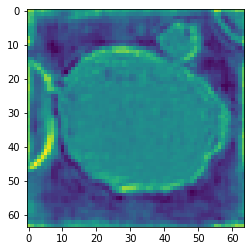

In [12]:
# plot output image just after the illumination layer before training

Illum_weights = custom_model.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)


In [13]:
# print illumination weight before training
custom_model.layers[0].get_weights()

[array([[[[-0.01335473],
          [-0.02016878],
          [ 0.07363679],
          [-0.02754419],
          [ 0.01677422],
          [-0.10227008],
          [ 0.05177391],
          [-0.02526406],
          [ 0.0496581 ]]]], dtype=float32)]

In [14]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=30, batch_size = 32, validation_data=(x_test_illumination, y_test))

Epoch 1/30
150/150 [==============================] - 4s 15ms/step - loss: 0.5985 - accuracy: 0.7468 - val_loss: 0.4660 - val_accuracy: 0.8114
Epoch 2/30
150/150 [==============================] - 2s 11ms/step - loss: 0.3735 - accuracy: 0.8633 - val_loss: 0.3910 - val_accuracy: 0.8609
Epoch 3/30
150/150 [==============================] - 2s 10ms/step - loss: 0.3210 - accuracy: 0.8866 - val_loss: 0.3405 - val_accuracy: 0.8751
Epoch 4/30
150/150 [==============================] - 2s 12ms/step - loss: 0.2671 - accuracy: 0.9069 - val_loss: 0.3235 - val_accuracy: 0.8927
Epoch 5/30
150/150 [==============================] - 2s 11ms/step - loss: 0.2367 - accuracy: 0.9182 - val_loss: 0.2973 - val_accuracy: 0.8961
Epoch 6/30
150/150 [==============================] - 2s 11ms/step - loss: 0.2197 - accuracy: 0.9205 - val_loss: 0.2843 - val_accuracy: 0.9053
Epoch 7/30
150/150 [==============================] - 2s 11ms/step - loss: 0.1935 - accuracy: 0.9312 - val_loss: 0.2747 - val_accuracy: 0.9137

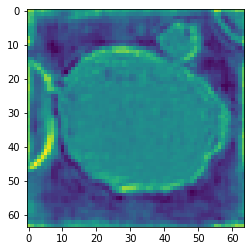

In [15]:
# plot output image just after the illumination layer after training
Illum_weights = custom_model.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)


In [16]:
# print illumination weight after training
custom_model.layers[0].get_weights()

[array([[[[-0.01335473],
          [-0.02016878],
          [ 0.07363679],
          [-0.02754419],
          [ 0.01677422],
          [-0.10227008],
          [ 0.05177391],
          [-0.02526406],
          [ 0.0496581 ]]]], dtype=float32)]

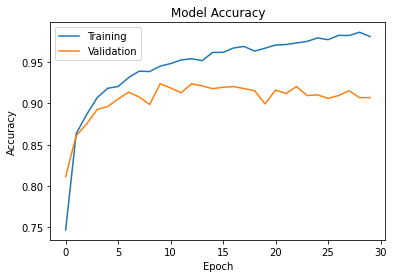

In [17]:
# plot the training and validation accuracies throughout training

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


## 1 (b)

In [18]:
# Reuse the code from above except now allow the weights to be trainable

class Illumination_trainable(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination_trainable, self).__init__()

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        w_init = tf.random_normal_initializer(mean=0.0, stddev=0.05)
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,input_shape[-1],1)),trainable=True)
    
    def call(self, inputs):
        #return tf.keras.layers.Conv2D(filters=9, kernel_size=1, strides=1, padding='same', activation='relu')
        result = tf.nn.conv2d(inputs, self.w, [1,1,1,1], padding='SAME')
        return tf.nn.relu(result)


In [19]:
image_size = (64, 64, 9)
custom_model_trainable = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination_trainable(),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model_trainable.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_trainable (Ill  (None, 64, 64, 1)        9         
 umination_trainable)                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 6)         906       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 6)        0         
 2D)                                                             
                                                      

In [20]:
custom_model_trainable.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

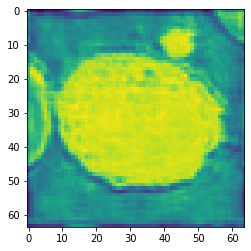

In [21]:
# plot output image just after the illumination layer before training

Illum_weights = custom_model_trainable.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)

In [22]:
# print illumination weight before training
custom_model_trainable.layers[0].get_weights()

[array([[[[-0.00551997],
          [ 0.07089297],
          [-0.0685009 ],
          [-0.0774808 ],
          [-0.06082061],
          [-0.0175633 ],
          [-0.02537853],
          [ 0.00098776],
          [-0.06112451]]]], dtype=float32)]

In [23]:
# train model
history_trainable = custom_model_trainable.fit(x_train_illumination, y_train, epochs=30, batch_size = 32, validation_data=(x_test_illumination, y_test))

Epoch 1/30
150/150 [==============================] - 3s 15ms/step - loss: 0.5642 - accuracy: 0.7541 - val_loss: 0.3259 - val_accuracy: 0.8919
Epoch 2/30
150/150 [==============================] - 2s 12ms/step - loss: 0.2583 - accuracy: 0.9092 - val_loss: 0.2044 - val_accuracy: 0.9321
Epoch 3/30
150/150 [==============================] - 2s 13ms/step - loss: 0.1908 - accuracy: 0.9312 - val_loss: 0.1674 - val_accuracy: 0.9539
Epoch 4/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1603 - accuracy: 0.9457 - val_loss: 0.1680 - val_accuracy: 0.9405
Epoch 5/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1462 - accuracy: 0.9476 - val_loss: 0.1593 - val_accuracy: 0.9514
Epoch 6/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1365 - accuracy: 0.9499 - val_loss: 0.1851 - val_accuracy: 0.9455
Epoch 7/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1259 - accuracy: 0.9522 - val_loss: 0.1674 - val_accuracy: 0.9438

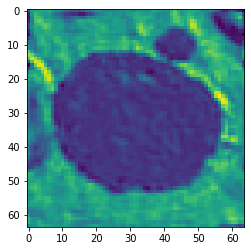

In [24]:
# plot output image just after the illumination layer after training
Illum_weights = custom_model_trainable.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)

In [25]:
# print illumination weight after training
custom_model_trainable.layers[0].get_weights()

[array([[[[ 0.08506591],
          [ 0.20188966],
          [ 0.00228338],
          [-0.14090419],
          [-0.04668131],
          [-0.03763862],
          [-0.06864778],
          [ 0.19792707],
          [ 0.08179838]]]], dtype=float32)]

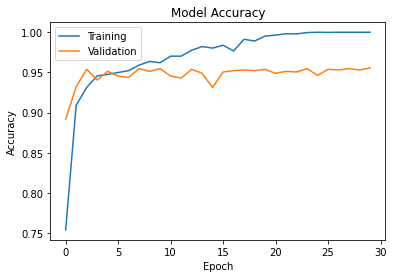

In [26]:
# plot the training and validation accuracies throughout training

plt.plot(history_trainable.history['accuracy'])
plt.plot(history_trainable.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


## 1 (c)
hint: tf.keras.layers.GaussianNoise(0.05)

In [27]:
# Reuse the code from above except add noise

class Illumination_trainable_noise(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination_trainable_noise, self).__init__()

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        w_init = tf.random_normal_initializer(mean=0.0, stddev=0.05)
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,input_shape[-1],1)),trainable=True)
    
    def call(self, inputs):
        #return tf.keras.layers.Conv2D(filters=9, kernel_size=1, strides=1, padding='same', activation='relu')
        result = tf.nn.conv2d(inputs, self.w, [1,1,1,1], padding='SAME')
        return tf.nn.relu(result)

In [28]:
image_size = (64, 64, 9)
custom_model_trainable_noise = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination_trainable_noise(),
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model_trainable_noise.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_trainable_nois  (None, 64, 64, 1)        9         
 e (Illumination_trainable_n                                     
 oise)                                                           
                                                                 
 gaussian_noise (GaussianNoi  (None, 64, 64, 1)        0         
 se)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 6)        

In [29]:
custom_model_trainable_noise.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

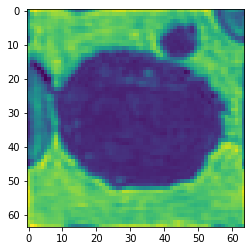

In [30]:
# plot output image just after the illumination layer before training

Illum_weights = custom_model_trainable_noise.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)

In [31]:
# print illumination weight before training
custom_model_trainable_noise.layers[0].get_weights()

[array([[[[ 0.06638806],
          [ 0.0134956 ],
          [ 0.0399438 ],
          [ 0.09070842],
          [ 0.01777619],
          [ 0.02234   ],
          [ 0.03794534],
          [-0.00590805],
          [-0.03136453]]]], dtype=float32)]

In [32]:
# train model
history_trainable_noise = custom_model_trainable_noise.fit(x_train_illumination, y_train, epochs=30, batch_size = 32, validation_data=(x_test_illumination, y_test))

Epoch 1/30
150/150 [==============================] - 3s 15ms/step - loss: 0.4955 - accuracy: 0.8031 - val_loss: 0.2414 - val_accuracy: 0.9162
Epoch 2/30
150/150 [==============================] - 2s 12ms/step - loss: 0.2209 - accuracy: 0.9235 - val_loss: 0.1902 - val_accuracy: 0.9329
Epoch 3/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1778 - accuracy: 0.9377 - val_loss: 0.1806 - val_accuracy: 0.9422
Epoch 4/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1622 - accuracy: 0.9405 - val_loss: 0.1457 - val_accuracy: 0.9614
Epoch 5/30
150/150 [==============================] - 2s 15ms/step - loss: 0.1292 - accuracy: 0.9564 - val_loss: 0.1887 - val_accuracy: 0.9455
Epoch 6/30
150/150 [==============================] - 3s 17ms/step - loss: 0.1185 - accuracy: 0.9616 - val_loss: 0.1351 - val_accuracy: 0.9656
Epoch 7/30
150/150 [==============================] - 3s 17ms/step - loss: 0.0959 - accuracy: 0.9658 - val_loss: 0.1362 - val_accuracy: 0.9631

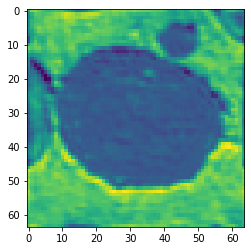

In [33]:
# plot output image just after the illumination layer after training
Illum_weights = custom_model_trainable_noise.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)

In [34]:
# print illumination weight after training
custom_model_trainable_noise.layers[0].get_weights()

[array([[[[ 0.15625927],
          [ 0.00193766],
          [ 0.13999066],
          [ 0.24612305],
          [ 0.14708939],
          [ 0.10439403],
          [-0.08427902],
          [-0.0885935 ],
          [-0.14270093]]]], dtype=float32)]

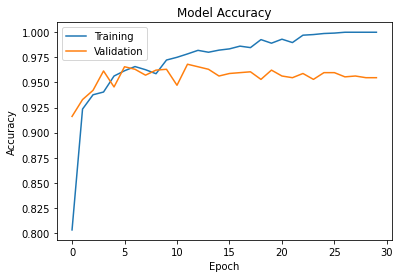

In [35]:
# plot the training and validation accuracies throughout training

plt.plot(history_trainable_noise.history['accuracy'])
plt.plot(history_trainable_noise.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


## 1 (d)

In [38]:
# Reuse the code from above except add non-neg constraint

class NonNegative(tf.keras.constraints.Constraint):
    def call(self, w):
        return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)

class Illumination_trainable_noise_nonneg(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination_trainable_noise_nonneg, self).__init__()

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        w_init = tf.random_normal_initializer(mean=0.0, stddev=0.05)
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,input_shape[-1],1)),trainable=True)
    
    def call(self, inputs):
        #return tf.keras.layers.Conv2D(filters=9, kernel_size=1, strides=1, padding='same', activation='relu')
        result = tf.nn.conv2d(inputs, self.w, [1,1,1,1], padding='SAME')
        return tf.nn.relu(result)


In [39]:
image_size = (64, 64, 9)
custom_model_trainable_noise_nonneg = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination_trainable_noise_nonneg(),
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax', kernel_constraint = NonNegative())])  

custom_model_trainable_noise_nonneg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_trainable_nois  (None, 64, 64, 1)        9         
 e_nonneg_1 (Illumination_tr                                     
 ainable_noise_nonneg)                                           
                                                                 
 gaussian_noise_2 (GaussianN  (None, 64, 64, 1)        0         
 oise)                                                           
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 6)        

In [40]:
custom_model_trainable_noise_nonneg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

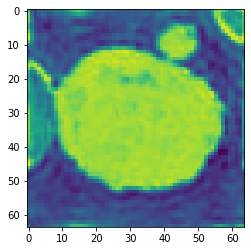

In [41]:
# plot output image just after the illumination layer before training

Illum_weights = custom_model_trainable_noise_nonneg.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)

In [42]:
# print illumination weight before training
custom_model_trainable_noise_nonneg.layers[0].get_weights()

[array([[[[-0.06848449],
          [-0.03836343],
          [-0.02205069],
          [-0.0109294 ],
          [ 0.0144042 ],
          [-0.01409161],
          [ 0.01375611],
          [-0.01490097],
          [ 0.02670326]]]], dtype=float32)]

In [43]:
# train model
history_trainable_noise_nonneg = custom_model_trainable_noise_nonneg.fit(x_train_illumination, y_train, epochs=30, batch_size = 32, validation_data=(x_test_illumination, y_test))

Epoch 1/30
150/150 [==============================] - 3s 16ms/step - loss: 0.6744 - accuracy: 0.7136 - val_loss: 0.3485 - val_accuracy: 0.8701
Epoch 2/30
150/150 [==============================] - 2s 13ms/step - loss: 0.2954 - accuracy: 0.9008 - val_loss: 0.2355 - val_accuracy: 0.9262
Epoch 3/30
150/150 [==============================] - 2s 12ms/step - loss: 0.2159 - accuracy: 0.9235 - val_loss: 0.1877 - val_accuracy: 0.9438
Epoch 4/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1669 - accuracy: 0.9474 - val_loss: 0.1800 - val_accuracy: 0.9396
Epoch 5/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1427 - accuracy: 0.9497 - val_loss: 0.1711 - val_accuracy: 0.9489
Epoch 6/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1328 - accuracy: 0.9558 - val_loss: 0.1827 - val_accuracy: 0.9413
Epoch 7/30
150/150 [==============================] - 2s 12ms/step - loss: 0.1110 - accuracy: 0.9627 - val_loss: 0.1685 - val_accuracy: 0.9480

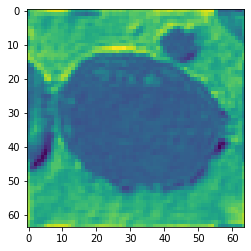

In [44]:
# plot output image just after the illumination layer after training
Illum_weights = custom_model_trainable_noise_nonneg.layers[0].get_weights()
Illum_weights = np.array(Illum_weights)
Weights_vector = Illum_weights[0,0,0,:,0]
x_train_illumination_example = x_train_illumination[0,:,:,:]
Illuminated_sum = np.matmul(x_train_illumination_example,Weights_vector)
plt.imshow(Illuminated_sum)

In [45]:
# print illumination weight after training
custom_model_trainable_noise_nonneg.layers[0].get_weights()

[array([[[[ 0.01902155],
          [-0.10528528],
          [-0.12903933],
          [-0.08231128],
          [ 0.11579441],
          [ 0.15720372],
          [ 0.12208771],
          [ 0.215989  ],
          [ 0.18896355]]]], dtype=float32)]

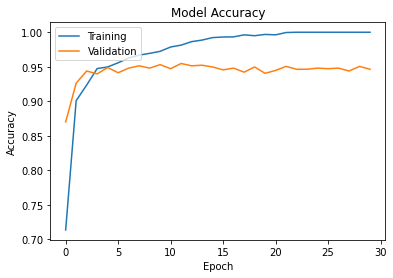

In [46]:
# plot the training and validation accuracies throughout training

plt.plot(history_trainable_noise_nonneg.history['accuracy'])
plt.plot(history_trainable_noise_nonneg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Analysis of Results:

# for 1a we were able to optimize the weights and perform the clssification task to a high degree (roughly 92% validation accuracy 
# for the best epoch) even without optimizing the illumination pattern.  As expected, once we allowed optimization of the illumination
# pattern in 1b we saw an increase in validation accuracy (up to roughly 95% for the best epoch).  For 1b we also confirmed that the
# weights were altered from the training process and the image was visibly illuminated differently.  For 1c we saw a further increase
# in accuracy with the introduction of gaussian noise ( roughly a 96% validation accuracy for the best epoch).  Finally, in 1d I was not
# able to get the weights to be non negative.  